# 18.模仿学习（Imitation Learning，简称IL）
> 虽然 **强化学习** 不需要有监督学习中的标签数据，但它十分依赖 **奖励函数** 的设置。有时在 **奖励函数** 上做一些微小的改动，训练出来的策略就会有天差地别。而且在现实场景中， **奖励信号** 总是难以明确：
- 例如，对于无人驾驶车辆智能体的规控，其观测是当前的环境感知恢复的 3D 局部环境，动作是车辆接下来数秒的具体路径规划，那么奖励是什么？如果只是规定正常行驶而不发生碰撞的奖励为+1，发生碰撞为-100，那么智能体学习的结果则很可能是找个地方停滞不前。**奖励函数** 往往需要精心设计和调试。
> 那有什么方法可以跳过 **奖励函数** 的设计呢？

> **模仿学习** 研究的便是这一类问题，在模仿学习的框架下，存在 **专家智能体**，其在某个环境下提供的一系列 **状态动作对**，被认为是 **最优行为策略**。**模仿者**的任务则是利用这些 **专家数据** 进行训练，**无须奖励信号** 就可以达到一个接近专家的策略。
> 学术界关于 **模仿学习** 的传统核心方法分为 **3 类**：

| 方法                                                            | 概念                                                                                           | 缺点                      | 适用任务                                 | 最早时间 | 论文链接                                                                                                     |
|---------------------------------------------------------------|----------------------------------------------------------------------------------------------|-------------------------|--------------------------------------|------|----------------------------------------------------------------------------------------------------------|
| **行为克隆（behavior cloning，BC）**                                 | 通过监督学习模仿专家的状态-动作对，直接复制专家的行为                                                                  | - 缺乏长期奖励优化<br> - 数据依赖性强 | 数据充足且专家行为完美的任务，如机器人抓取、路径规划等          | 1988 | [论文学习](https://papers.neurips.cc/paper_files/paper/1988/file/812b4ba287f5ee0bc9d43bbf5bbe87fb-Paper.pdf) |
| **逆强化学习（inverse RL）**                                         | 不同于行为克隆仅仅是复制专家的动作，它的目标是从专家的行为中推断出奖励函数。通过推断奖励函数，智能体就可以基于奖励来优化自己的策略了                           | - 计算复杂度高<br> - 数据需求大    | 无法直接获取奖励信号或奖励函数难以设计的任务，如自主驾驶、复杂策略规划。 | 2000 | [论文学习](https://www.cl.cam.ac.uk/~ey204/teaching/ACS/R244_2022_2023/papers/NG_ICML_2000.pdf)              |
| **生成式对抗模仿学习（generative adversarial imitation learning，GAIL）** | 结合生成对抗网络（GANs）将模仿学习视为一个对抗过程，其中一个生成器（模仿者）试图模仿专家的行为，另一个判别器（判别器）则尝试判断动作是否来自专家。最终，生成器学会如何模仿专家的策略 | - 训练不稳定<br> - 对样本质量敏感   | 没有明确奖励信号的复杂任务，如机器人运动、视频游戏AI等。        | 2016 | [论文学习](https://arxiv.org/abs/1606.03476)                                                                 |


> 本节主要介绍 **行为克隆** 和 **生成式对抗模仿学习**
> **逆强化学习** 有良好的学术贡献，但由于其计算复杂度较高，实际应用的价值较小

## 18.1 行为克隆
> **行为克隆（BC）** 直接使用 **监督学习** 方法：
$$\theta^*=\arg\min_\theta\mathbb{E}_{(s,a)\sim B}[\mathcal{L}(\pi_\theta(s),a)]$$
- $B$是专家的数据集，$\mathcal{L}$是对应监督学习框架下的损失函数
- 若动作是离散的，该损失函数可以是最大似然估计得到的；若动作是连续的，该损失函数可以是均方误差函数
> 但也造成了其存在很大的局限性：由于训练使用的 **专家数据** 难以囊括所有状态分布，因此 BC 只能在专家数据的状态分布下预测得比较准。而且，**强化学习** 面对的是一个序贯决策问题，只要存在一点偏差，就有可能导致下一个遇到的状态是在专家数据中没有见过的。此时，由于没有在此状态（或者比较相近的状态）下训练过，策略可能就会随机选择一个动作，这会导致下一个状态 **进一步偏离** 专家策略遇到的的数据分布。最终，该策略在真实环境下不能得到比较好的效果，这被称为行为克隆的 **复合误差（compounding error）** 问题：
![行为克隆带来的复合误差问题](Illustrations/行为克隆带来的复合误差问题.png)
> 即使 **行为克隆** 有这些局限，但其实现十分简单，因此在很多实际场景下它都可以作为 **策略预训练** 的方法：使 **策略** 无须在 **最开始低效地** 通过和环境交互来探索较好的动作，而是通过模仿专家智能体的行为数据来 **快速达到较高水平**，为接下来的强化学习创造一个 **高起点**。

## 18.2 生成式对抗模仿学习
> **生成式对抗模仿学习** 是2016年由斯坦福大学研究团队提出的 **基于生成式对抗网络** 的**模仿学习**，它诠释了**生成式对抗网络**的 **本质** 其实就是**模仿学习**
> **GAIL** 算法中有一个 **判别器** 和一个 **策略**：
- **策略** 就相当于是生成式对抗网络中的 **生成器（generator）**，给定一个状态，**策略** 会输出这个状态下应该采取的动作
- **判别器（discriminator）$D_\phi$** 将状态动作对$(s,a)$作为输入，输出一个 0 到 1 之间的实数，表示 **判别器** 认为该状态动作对来自 **智能体策略$\theta$** 而非 **专家$E$** 的概率。**判别器** 的目标是尽量将专家数据的输出靠近 0，将模仿者策略的输出靠近 1，这样就可以 **将两组数据分辨开**。

> 于是**判别器$D_\phi$** 的目标是最大化对数似然：
$$\mathcal{L}_D(\phi)=\mathbb{E}_{(s,a)\sim\pi_\theta}[\log D_\phi(s,a)]+\mathbb{E}_{(s,a)\sim\pi_E}[\log(1-D_\phi(s,a))]$$

> 实际训练时，取负，最小化 **损失函数（Binary Cross-Entropy Loss for Discriminator）**：
$$\min_\phi-\mathcal{L}_D(\phi)=-\mathbb{E}_{(s,a)\sim\pi_\theta}[\log D_\phi(s,a)]-\mathbb{E}_{(s,a)\sim\pi_E}[\log(1-D_\phi(s,a))]$$

> 本质上为 **二分类交叉熵损失 BCELoss（Binary Cross-Entropy Loss）**，依据**真实采样分布**计算与**预测分布**的差异：
$$\mathrm{BCE}(p,y)=-\left(y\cdot\log(p)+(1-y)\cdot\log(1-p)\right)$$

> 有了 **判别器$D_\phi$** 之后，**策略** 的目标就是其交互产生的轨迹能被 **判别器** 误认为专家轨迹，所以将 **判别器的输出** 作为 **奖励函数** 来训练 **模拟者的策略**：
$$r(s,a)=-\log D(s,a)$$

- **在不断的对抗过程中**：训练初期，**判别器**能够轻易区分专家数据和策略数据，因而对专家样本输出接近 0、对策略样本输出接近 1；随着**策略**不断更新以获得更高奖励，它会逐渐生成更接近专家的数据分布，使得**判别器**的区分难度增大，输出趋于模糊；在理论上的收敛点（**纳什均衡**）时，**策略分布与专家分布**完全一致，**判别器**无法再区分二者，只能对所有样本给出约 0.5 的概率，从而体现出博弈的平衡。

> 可见，**GAIL** 中的 **策略** 需要和环境进行交互，这一点和 **BC** 不同，**BC** 完全不需要和环境交互
> **GAIL** 实质上是模仿了 **专家策略的占用度量**，即 **尽量使得** 在环境中 **策略的占用度量$\rho_{\pi}(s,a)$** 和 **专家策略的占用度量$\rho_{E}(s,a)$** 一致：
![GAIL的优化目标](Illustrations/GAIL的优化目标.png)

## 18.3 代码实践（CartPole-v1）
- 生成专家数据
- **行为克隆** 算法实现
- **生成式对抗模仿学习** 算法实现

导入相关库：

In [38]:
# 基本库
import numpy as np
import random
from tqdm import tqdm

from utils.smoothing import moving_average
from utils.advantage import compute_advantage
from utils.training import train_on_policy_agent
# 神经网络
import torch
import torch.nn.functional as F
import torch.nn as nn
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

### 生成专家数据：
> 通过 **PPO** 算法训练出一个表现良好的专家模型，再利用专家模型生成专家数据

In [6]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
class PPO:
    """ PPO-Clip（离散动作） """
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs   # 一条序列的数据用来训练 epochs 轮
        self.eps = eps         # PPO-Clip 的范围参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states_np = np.array(transition_dict['states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        states = torch.tensor(states_np, dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states_np = np.array(transition_dict['next_states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        next_states = torch.tensor(next_states_np, dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)  # 时序差分目标
        td_delta = td_target - self.critic(states)                                 # 时序差分误差
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # Clip
            
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO 损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            

In [7]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env = gym.make('CartPole-v1')  # CartPole-v1 最大回合步数修改到了500步(v0为200)
#env = env.unwrapped # 获取原始环境（绕过 TimeLimit 包装器）解除最大步数500限制
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


In [8]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128

lmbda = 0.95
eps = 0.2
actor_lr = 1e-3
critic_lr = 1e-2
gamma = 0.98
epochs = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
num_episodes = 500

In [9]:
return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s, episode=500, return=500.000]


*采样 $n$ 条轨迹：*

In [47]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        episode_return = 0
        state, info = env.reset()  # 初始环境状态可不固定，所经历的状态动作对仍具有指导意义
        done = False
        truncated = False
        while not (done or truncated):  # 任务失败或达到最大步数
            action = agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, truncated, _ = env.step(action)  # Gymnasium返回值不一样
            state = next_state
            episode_return += reward
        print(episode_return)
    return np.array(states), np.array(actions)

*只生成一条轨迹：*

In [48]:
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

500.0


*再从中采样 $n$ 个数据对：*

In [49]:
n_samples = 100
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]
print(expert_s,expert_a)

[[ 2.72294104e-01 -1.43354103e-01  1.28104910e-02  8.42272341e-02]
 [ 1.48016974e-01 -3.35696250e-01 -1.32817896e-02  3.15589637e-01]
 [ 3.12507570e-01  2.30062470e-01 -5.39715728e-03 -1.29989833e-01]
 [ 2.22945094e-01  2.30974346e-01 -1.72858331e-02 -1.50121838e-01]
 [ 2.64835984e-01  2.32678816e-01  1.98677983e-02 -1.87747002e-01]
 [ 1.27989084e-01 -1.57186851e-01  6.43744017e-04  3.89326453e-01]
 [ 2.11684808e-01 -1.49385318e-01  9.21558887e-02  2.18304589e-01]
 [ 1.75344989e-01 -1.43024594e-01 -1.91703420e-02  7.69324079e-02]
 [ 1.44222930e-01  2.32494533e-01 -4.75422805e-03 -1.83631346e-01]
 [ 2.28015080e-01  3.09144799e-02  9.77818370e-02  2.52831399e-01]
 [ 3.30983400e-01 -1.41496301e-01 -7.71247549e-03  4.32408191e-02]
 [ 3.72572511e-01 -3.39166164e-01 -5.57604879e-02  3.92826676e-01]
 [ 4.18744504e-01 -7.07926929e-01  1.12969112e-02  5.03783166e-01]
 [ 1.95612431e-01 -1.53549373e-01 -3.73520106e-02  3.09340477e-01]
 [ 1.83799192e-01  3.92020196e-02 -3.05673983e-02  6.87291548e

### 行为克隆的代码实践:

*行为克隆算法：*

In [50]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))  # 提取当前策略网络对应动作的概率
        bc_loss = torch.mean(-log_probs)  # 最大似然估计，最大化对应动作概率

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

*一次克隆后，测试策略网络效果：*

In [53]:
def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state, info = env.reset()  # 初始环境状态可不固定
        done = False
        truncated = False
        while not (done or truncated):  # 任务失败或达到最大步数
            action = agent.take_action(state)
            next_state, reward, done, truncated, _ = env.step(action)  # Gymnasium返回值不一样
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

*参数设置：*

In [54]:
lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 128

*训练：*

In [55]:
test_returns = []
with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,
                                           high=expert_s.shape[0],
                                           size=batch_size)  # randint 是有放回采样
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 1000/1000 [38:43<00:00,  2.32s/it, return=303.140]


*实际上，在**初始环境固定**的情况下，**BC** 更加难以学习到 **最优策略**，因为依旧**不完全**的信息数据，会导致学习容易发生**过拟合***


### 生成式对抗模仿学习的代码实践:

*判别器模型：*
> 两层的全连接网络
> 模型输入为一个状态动作对，输出一个概率标量

In [67]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))

***生成式对抗模仿学习：***
> 每一轮迭代中：
> 1. **GAIL** 中的策略和环境交互，采样**新的状态动作对**
> 2. 基于已有 **专家数据** 和 **策略新采样的数据** ，首先训练 **判别器**
> 3. 然后将 **判别器** 的输出转换为 **策略的奖励信号**，指导策略用 **PPO** 算法做训练

In [68]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a).to(device)
        agent_states = torch.tensor(np.array(agent_s), dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_a).to(device)
        # 独热编码
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()
        # 判断器更新
        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(
            agent_prob, torch.ones_like(agent_prob)) + nn.BCELoss()(
                expert_prob, torch.zeros_like(expert_prob))  # 判别器的二分类交叉熵损失
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()
        # 策略更新
        rewards = -torch.log(agent_prob).detach().cpu().numpy()  # 不使用环境反馈的奖励
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)

*参数设置：*

In [69]:
agent_gail = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
lr_d = 1e-3
gail = GAIL(agent_gail, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500

*训练：*

In [70]:
return_list = []
with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state, info = env.reset()
        done = False
        truncated = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not (done or truncated):  # 任务失败或达到最大步数
            action = agent_gail.take_action(state)
            next_state, reward, done, truncated, _ = env.step(action)  # Gymnasium返回值不一样
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 500/500 [06:22<00:00,  1.31it/s, return=500.000]


#### 绘图对比：

In [71]:
import pandas as pd
episodes_list_bc = list(range(len(test_returns)))
mv1_return = moving_average(test_returns, 9)
episodes_list_gail = list(range(len(return_list)))
mv2_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list_bc, 'Returns': mv1_return})
df2 = pd.DataFrame({'Episodes': episodes_list_gail, 'Returns': mv2_return})
# 保存为 CSV 文件
df1.to_csv('PPO_bc_CartPole-v1_mv_returns_data.csv', index=False)
df2.to_csv('PPO_gail_CartPole-v1_mv_returns_data.csv', index=False)

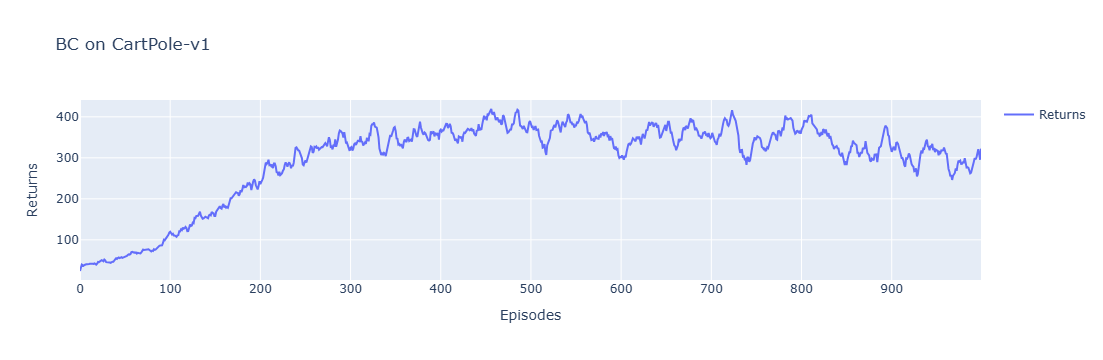

In [4]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('PPO_bc_CartPole-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='BC on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

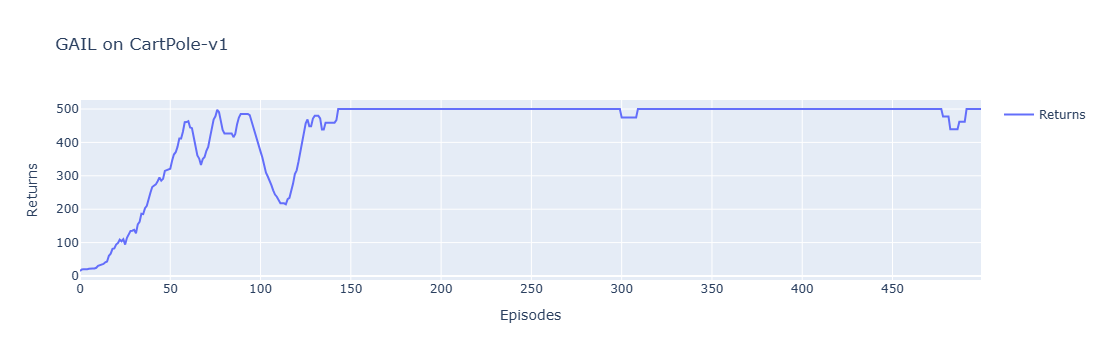

In [3]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('PPO_gail_CartPole-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='GAIL on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

*通过对比，可以感受到，在 **数据样本有限** 的情况下，**BC** 难以学习到 **最优策略**，而 **GAIL** 在 **相同的专家数据** 下则可以取得非常好的效果*
- 一方面归因于 **GAIL** 的训练目标是拉近策略和专家的**占用度量**，而非简单复制十分贴合模仿学习任务的目标，避免了 BC 中的 **复合误差问题**；
- 另一方面是在 **GAIL** 训练中，策略可以和环境交互出 **更多的数据**，并通过判别器，转化为了专门的 **策略更新指导奖励信号**。